In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import math
import numpy as np

Using TensorFlow backend.
c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\zeesh\anaco

In [2]:
(X_Train,_),(_,_) = mnist.load_data()  

In [3]:
print(X_Train.shape)
print(type(X_Train))

X_Train = X_Train.reshape((*(X_Train.shape),1))
print(X_Train.shape)

(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 28, 28, 1)


In [4]:
#Normalize the Data between -1 and 1

X_Train = (X_Train.astype('float32') - 127.5)/127.5

print(np.min(X_Train))
print(np.max(X_Train))

-1.0
1.0


In [5]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
NO_OF_BATCHES = math.ceil(X_Train.shape[0]/float(BATCH_SIZE))
HALF_BATCH_SIZE = int(BATCH_SIZE/2)

NOISE_DIM = 100

adam = Adam(lr=2e-4,beta_1=0.5)

In [6]:
#Upsampling 
# Start from 7 X 7 X 128
generator = Sequential()
generator.add(Dense(7*7*128,input_shape=(NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#Double the Activation Size 14 X 14 X 64
generator.add(UpSampling2D())
generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

# Double the Activation Size 28 X 28 X 1
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))

# Final Output (No ReLu or Batch Norm)
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()



#Discriminator - Downsampling
discriminator = Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))
discriminator.add(LeakyReLU(0.2))

# Prefer Strided Convolutions over MaxPooling
discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))
discriminator.add(LeakyReLU(0.2))


discriminator.add(Flatten())
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()

W0510 17:31:06.100441 22256 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0510 17:31:06.104440 22256 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0510 17:31:06.112441 22256 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0510 17:31:06.339532 22256 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
__________

In [11]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

#Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

def save_imgs(epoch,samples=100):
    noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_imgs[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(r'C:\Users\zeesh\Machine Learning\22.Generative Adversarial Networks (GANs)\DC GAN -MNISTimages/gan_output_epoch_{0}.png'.format(epoch+1))
    plt.show()
  


In [12]:
!mkdir images

A subdirectory or file images already exists.


In [13]:
X_Train.shape

(60000, 28, 28, 1)

In [ ]:
for epoch in range(NUM_EPOCHS):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    
    for step in range(NO_OF_BATCHES):
        #randomly select 50% real images
        idx = np.random.randint(0,X_Train.shape[0],HALF_BATCH_SIZE)
        real_imgs = X_Train[idx]
        
        # generate 50% random images
        noise = np.random.normal(0,1,size=(HALF_BATCH_SIZE,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        
        
        # one sided label smoothing
        real_y = np.ones((HALF_BATCH_SIZE,1))*0.9 #Label Smoothing, Works well in practice
        fake_y = np.zeros((HALF_BATCH_SIZE,1))
        
        # train on real and fake images
        d_loss_real = discriminator.train_on_batch(real_imgs,real_y) #updates the weights of discriminator
        d_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y) 
        d_loss = 0.5*d_loss_real + 0.5*d_loss_fake
        
        epoch_d_loss += d_loss
        
        
        #Train Generator (Complete Model Generator + Frozen Discriminator)
        
        noise = np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
        real_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,real_y)
        epoch_g_loss += g_loss
        
    print("Epoch %d D loss: %f G loss: %f" % ((epoch + 1), epoch_d_loss, epoch_g_loss))

    if (epoch+1)%10==0:
        generator.save(r'C:\Users\zeesh\Machine Learning\22.Generative Adversarial Networks (GANs)\DC GAN -MNISTmodels/gan_generator_{0}.h5'.format(epoch+1))
        save_imgs(epoch)

In [0]:
!ls

images	models	sample_data


In [0]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/gan_generator_30.h5 (deflated 8%)
  adding: content/models/gan_generator_50.h5 (deflated 8%)
  adding: content/models/gan_generator_40.h5 (deflated 8%)
  adding: content/models/gan_generator_10.h5 (deflated 8%)
  adding: content/models/gan_generator_20.h5 (deflated 8%)


In [0]:
from google.colab import files
files.download("/content/models.zip")

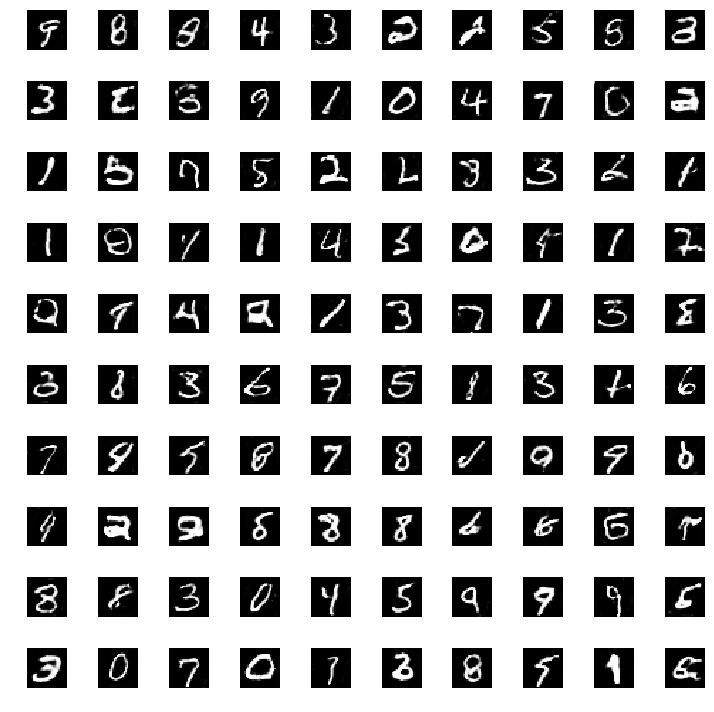

In [0]:
save_imgs(50)